In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

In [2]:
def load_features_from_dir(base_dir, distill=False):
    # Initialize a dictionary to store features
    if distill is False:
        features = {
            "output_features": [],
            "start_secs": [],
            "exo_cams": [],
            "video_ids": []
        }
    else:
        features = {
            "output_features": [],
            "target_features": [],
            "positive_feat_idxs": [],
            "start_secs": [],
            "exo_cams": [],
            "video_ids": []
        }
    # Check if the base directory exists
    if not os.path.isdir(base_dir):
        raise FileNotFoundError(f"The directory {base_dir} does not exist.")
    # Mapping of filenames to dictionary keys
    file_to_key = {
        "output_features.npy": "output_features",
        "ego_seq.npy": "target_features",
        "positive_feature_idxs_epoch.npy": "positive_feat_idxs"
    }
    # Traverse the directory structure
    #i = 0
    for root, dirs, files in os.walk(os.path.join(base_dir)):
        parts = root.split("/")
        if not parts[-3].startswith("georgiatech_covid"):
            continue
        #if i >= 10:
        #    break
        #i += 1
        if parts[-1].isdigit():
            features["start_secs"].append(parts[-1])
            features["exo_cams"].append(parts[-2])
            features["video_ids"].append(parts[-3])
        for file in files:
            if file in file_to_key and file_to_key[file] in features.keys():
                file_path = os.path.join(root, file)
                try:
                    data = np.load(file_path)
                    features[file_to_key[file]].append(data)
                except Exception as e:
                    print(f"Error loading {file_path}: {e}")
    return features

In [3]:
def compute_similarity_heatmap(input_features, target_features, positive_feat_idxs):
    heatmaps = []
    for inp, target, pos_idxs in zip(input_features, target_features, positive_feat_idxs):
        # Extract positive view features
        pos_features = np.array([target[pos_idx, i] for i, pos_idx in enumerate(pos_idxs)])
        # Compute cosine similarity between input features and positive view features
        similarity_matrix = cosine_similarity(inp, pos_features)
        # Append the similarity matrix to the list of heatmaps
        heatmaps.append(similarity_matrix)
    return heatmaps
    
def plot_heatmap(similarity_matrix, title="Similarity Heatmap"):
    plt.figure(figsize=(10, 8))
    plt.imshow(similarity_matrix, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.title(title)
    plt.xlabel("Positive View Features")
    plt.ylabel("Input Features")
    plt.show()

In [4]:
def normalize_features(features):
    # Flatten the list of feature arrays for normalization
    flattened_features = np.vstack(features)
    # Standardize features
    scaler = StandardScaler()
    normalized_features = scaler.fit_transform(flattened_features)
    # Reshape back to original structure
    split_indices = np.cumsum([len(f) for f in features[:-1]])
    return np.split(normalized_features, split_indices)
def extract_view_features(target_features, positive_feat_idxs):
    all_view_features = []
    positive_view_features = []
    for target, pos_idxs in zip(target_features, positive_feat_idxs):
        # Extract positive view features
        pos_features = np.array([target[pos_idx, i] for i, pos_idx in enumerate(pos_idxs)])
        positive_view_features.append(pos_features)
        # Remove zero rows (views that are not available)
        non_zero_views = target[np.any(target != 0, axis=(1, 2))]
        # Flatten the first two dimensions to get all view features
        all_views = non_zero_views.reshape(-1, target.shape[-1])
        # Remove positive view features from all views
        remaining_views = [view for view in all_views if not any(np.array_equal(view, pos) for pos in pos_features)]
        all_view_features.append(np.array(remaining_views))
    return all_view_features, positive_view_features

def apply_tsne(input_features, no_curr_features, output_features, all_view_features, positive_view_features):
    tsne_results = []
    for inp, nocurr, out, all_views, pos_views in tqdm(zip(input_features, no_curr_features, output_features, all_view_features, positive_view_features), total=len(input_features)):
        # Concatenate input, output, positive, and remaining view features
        combined_features = np.vstack((inp, nocurr, out, pos_views, all_views))
        # Apply t-SNE
        tsne = TSNE(n_components=2, random_state=42)
        tsne_result = tsne.fit_transform(combined_features)
        tsne_results.append(tsne_result)
    return tsne_results
    
def plot_tsne(tsne_result, input_len, no_curr_len, output_len, pos_len, video_id, exo_cam, start_sec, index, title="Video Features"):
    plt.figure(figsize=(10, 8))
    # Plot input features
    plt.scatter(tsne_result[:input_len, 0], tsne_result[:input_len, 1], label='w/o distill', alpha=0.5)
    # Plot no_curr features
    plt.scatter(tsne_result[input_len:input_len+no_curr_len, 0], tsne_result[input_len:input_len+no_curr_len, 1], label='distill+curriculum', alpha=0.5)

    # Plot output features
    plt.scatter(tsne_result[input_len+no_curr_len:input_len+no_curr_len+output_len, 0], tsne_result[input_len+no_curr_len:input_len+no_curr_len+output_len, 1], label='w/o curriculum', alpha=0.5)
    # Plot positive view features
    plt.scatter(tsne_result[input_len+no_curr_len+output_len:input_len+no_curr_len+output_len+pos_len, 0], tsne_result[input_len+no_curr_len+output_len:input_len+no_curr_len+output_len+pos_len, 1], label='Positive View Features', alpha=0.5)
    # Plot remaining view features
    plt.scatter(tsne_result[input_len+no_curr_len+output_len+pos_len:, 0], tsne_result[input_len+no_curr_len+output_len+pos_len:, 1], label='Remaining View Features', alpha=0.5)
    plt.title(f"Video: {video_id} Cam: {exo_cam} span: ({start_sec},{int(start_sec)+64}) s")
    plt.legend()
    plt.show()

In [5]:
runs_dir = "/private/home/arjunrs1/exo_narration_grounding/ExoGround/train/log/"
no_distill_model_name = "/private/home/arjunrs1/exo_narration_grounding/ExoGround/train/log/1ep_nodist_2024_11_12_06_40_joint_iou_l1_egoexo4d_len64_e6d6_bs16_lr0.0001_view=all_distill=False_pair_ds=False_pair_ds_mode=all_multi_ego=False_narr_rand=False"
no_curr_model_name = "/private/home/arjunrs1/exo_narration_grounding/ExoGround/train/log/1ep_curr_2024_11_12_06_30_joint_iou_l1_egoexo4d_len64_e6d6_bs16_lr0.0001_view=all_distill=True_pair_ds=False_pair_ds_mode=all_multi_ego=False_narr_rand=False"
distill_model_name = "/private/home/arjunrs1/exo_narration_grounding/ExoGround/train/log/1ep_nocurr_2024_11_12_06_34_joint_iou_l1_egoexo4d_len64_e6d6_bs16_lr0.0001_view=all_distill=True_pair_ds=False_pair_ds_mode=all_multi_ego=False_narr_rand=False"
no_distill_model_dir = os.path.join(runs_dir, no_distill_model_name, "log", "saved_features")
no_curr_model_dir = os.path.join(runs_dir, no_curr_model_name, "log", "saved_features")
distill_model_dir = os.path.join(runs_dir, distill_model_name, "log", "saved_features")

In [6]:
outputs_no_distill = load_features_from_dir(no_distill_model_dir)
outputs_no_curr = load_features_from_dir(no_curr_model_dir) #we don't set distill true here even though it is a distill mode, because we just want the output features
outputs_distill = load_features_from_dir(distill_model_dir, distill=True)

In [7]:
#Visualize heatmap:
#heatmaps = compute_similarity_heatmap(outputs['input_features'], outputs['target_features'], outputs['positive_feat_idxs'])
#plot_heatmap(heatmaps[0], title="Input/Target Similarity Heatmap for First Video")
#heatmaps = compute_similarity_heatmap(outputs['output_features'], outputs['target_features'], outputs['positive_feat_idxs'])
#plot_heatmap(heatmaps[0], title="Output/Target Similarity Heatmap for First Video")

In [8]:
#t-SNE:
# Normalize input and output features
print("Normalizing no distill features...")
normalized_input_features = normalize_features(outputs_no_distill['output_features'])
print("Normalizing no distill features...")
normalized_no_curr_features = normalize_features(outputs_no_curr['output_features'])
print("Normalizing features...")
normalized_output_features = normalize_features(outputs_distill['output_features'])

print("Extracting all-view and positive features...")
all_view_features, positive_view_features = extract_view_features(outputs_distill['target_features'], outputs_distill['positive_feat_idxs'])
print("Normalizing all_view_features features...")
normalized_all_view_features = normalize_features(all_view_features)
print("Normalizing positive_view features...")
normalized_positive_view_features = normalize_features(positive_view_features)

Normalizing no distill features...
Normalizing no distill features...
Normalizing features...
Extracting all-view and positive features...
Normalizing all_view_features features...
Normalizing positive_view features...


100%|██████████| 33/33 [00:57<00:00,  1.75s/it]


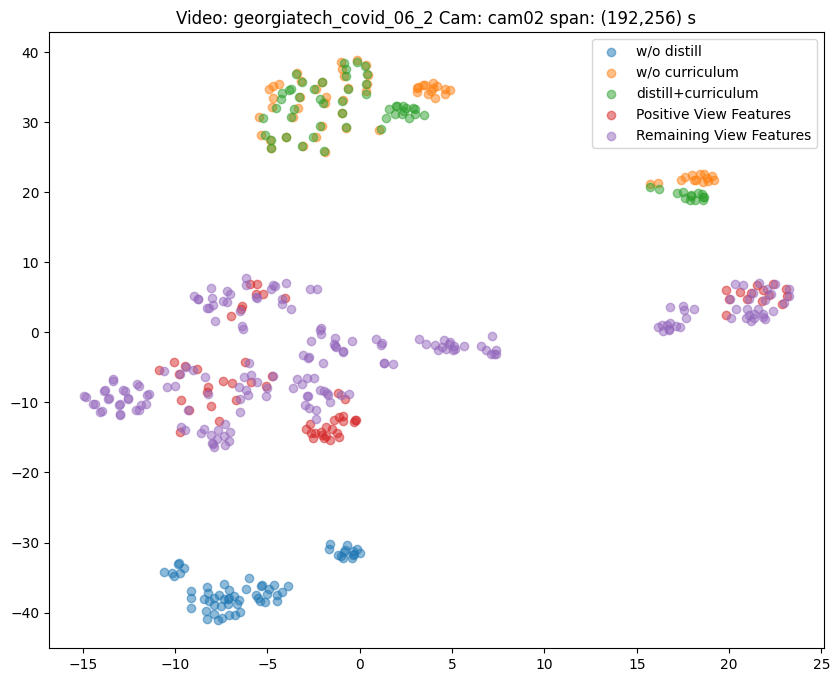

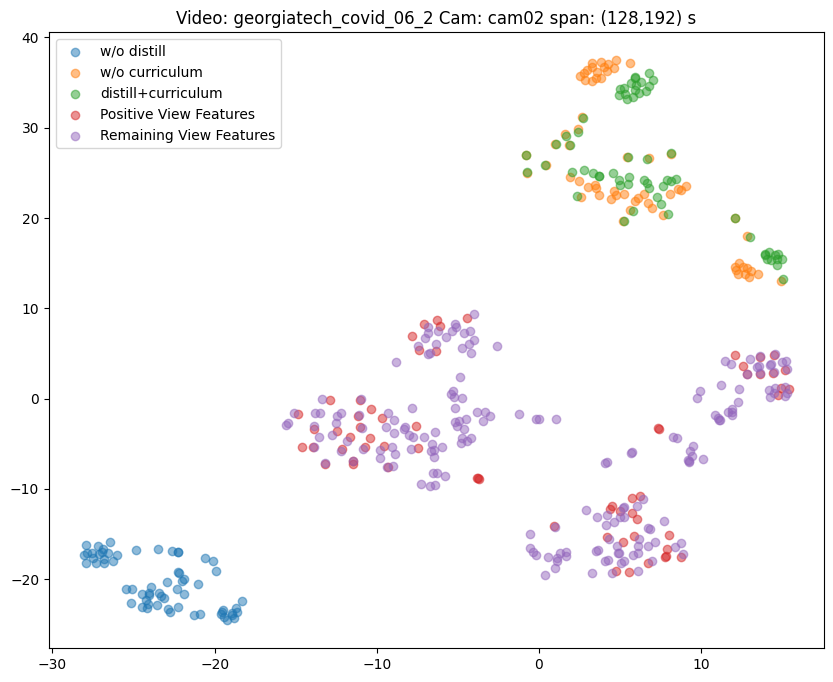

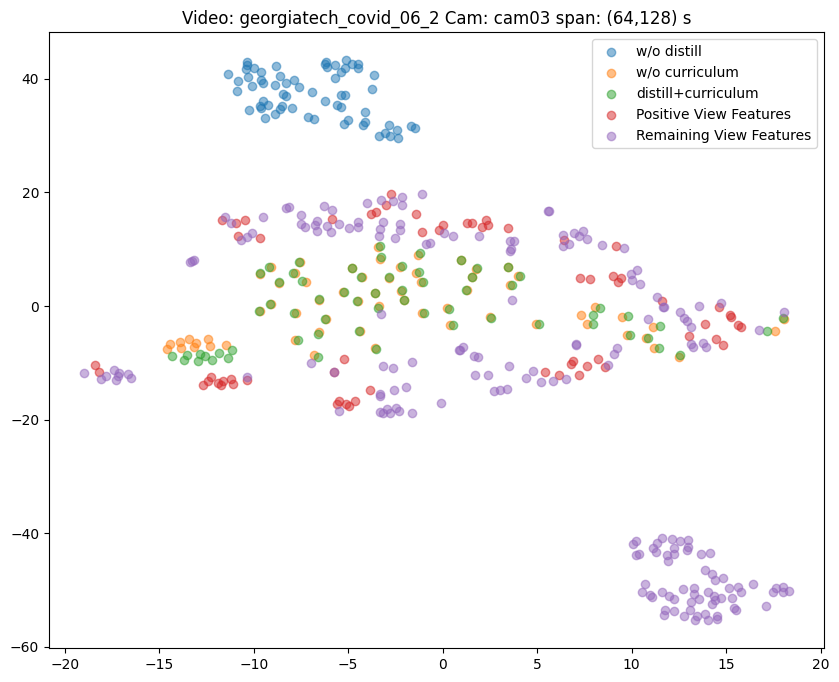

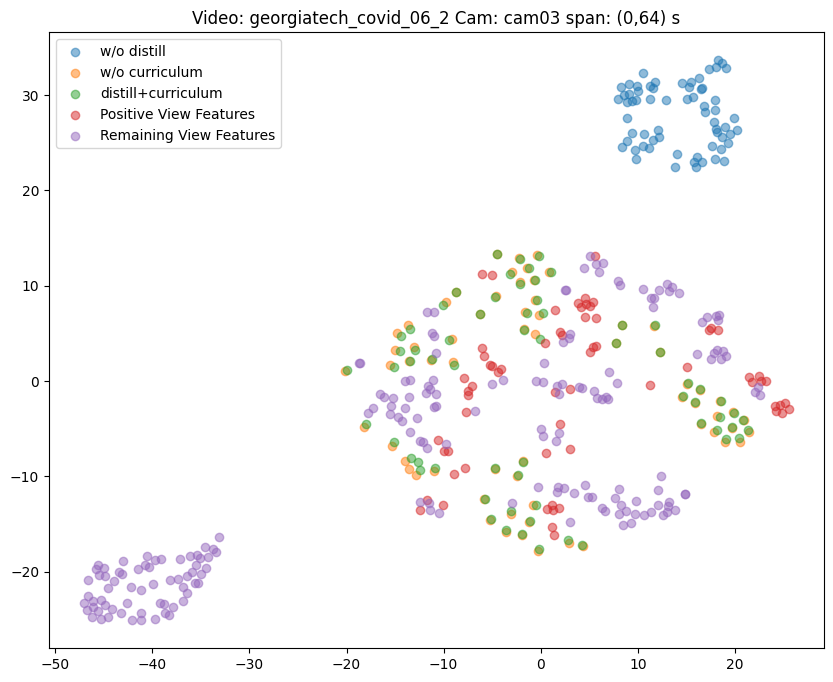

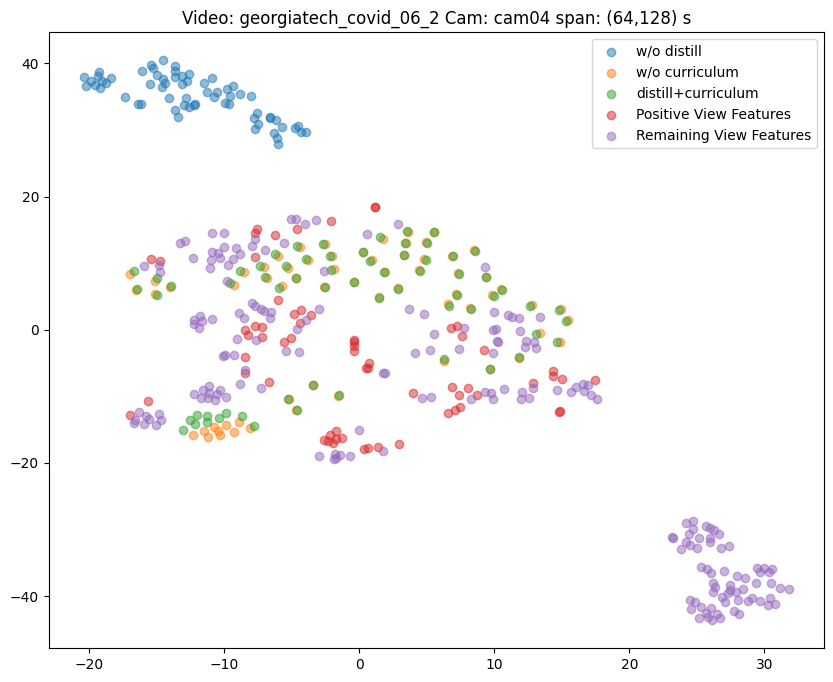

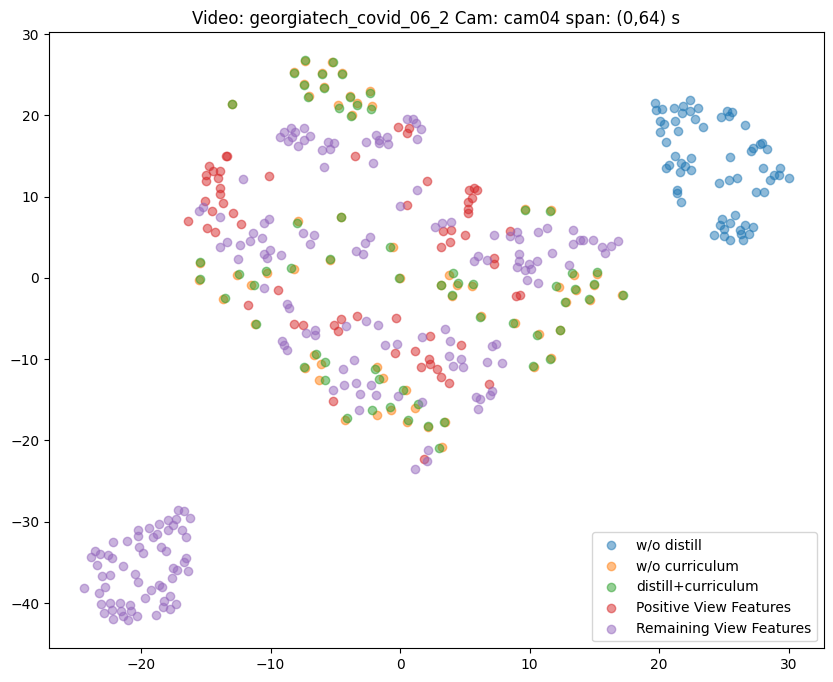

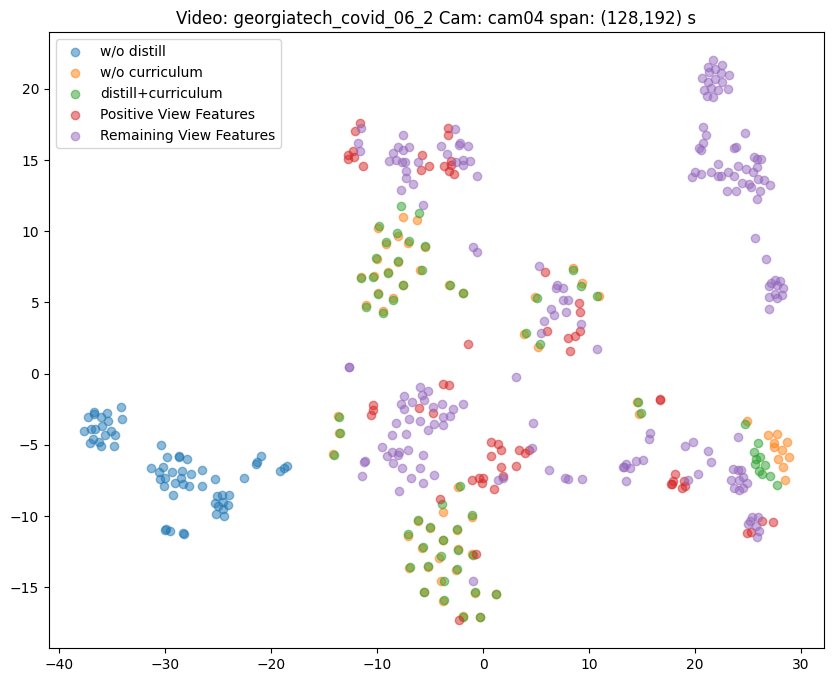

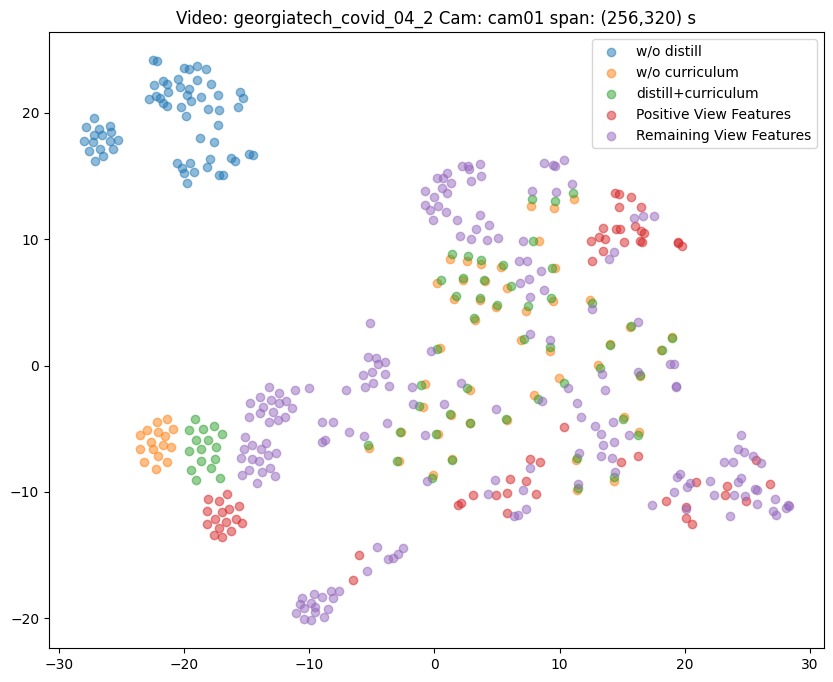

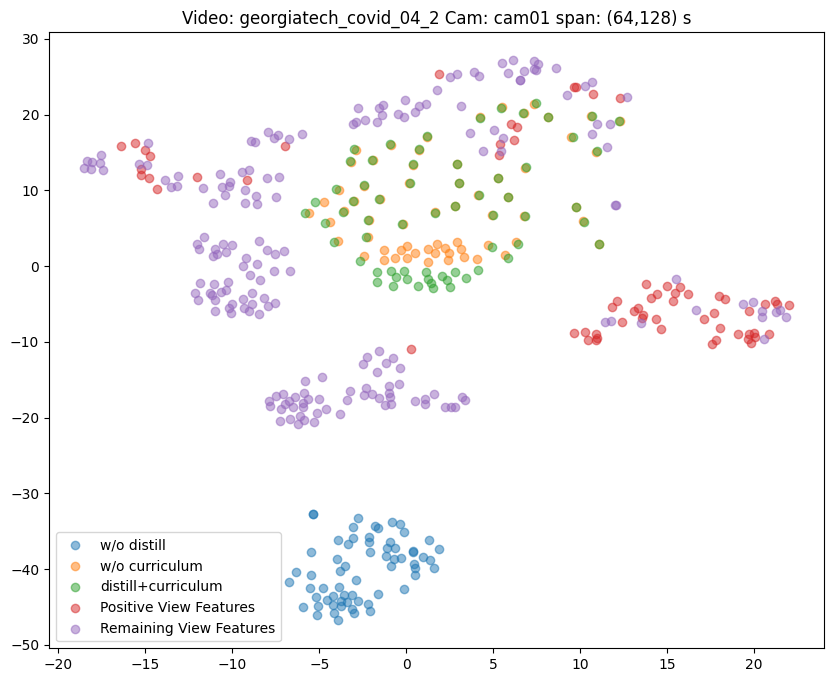

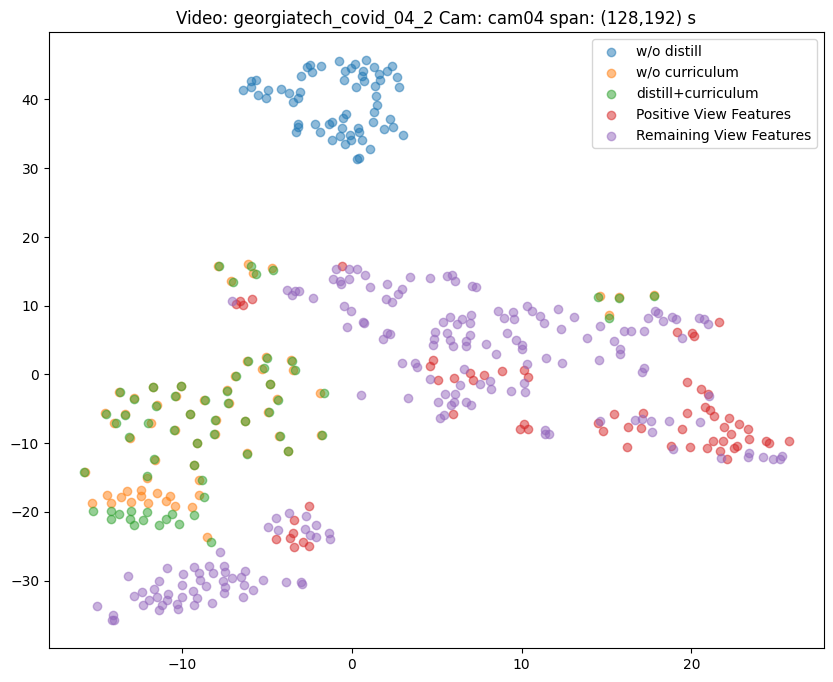

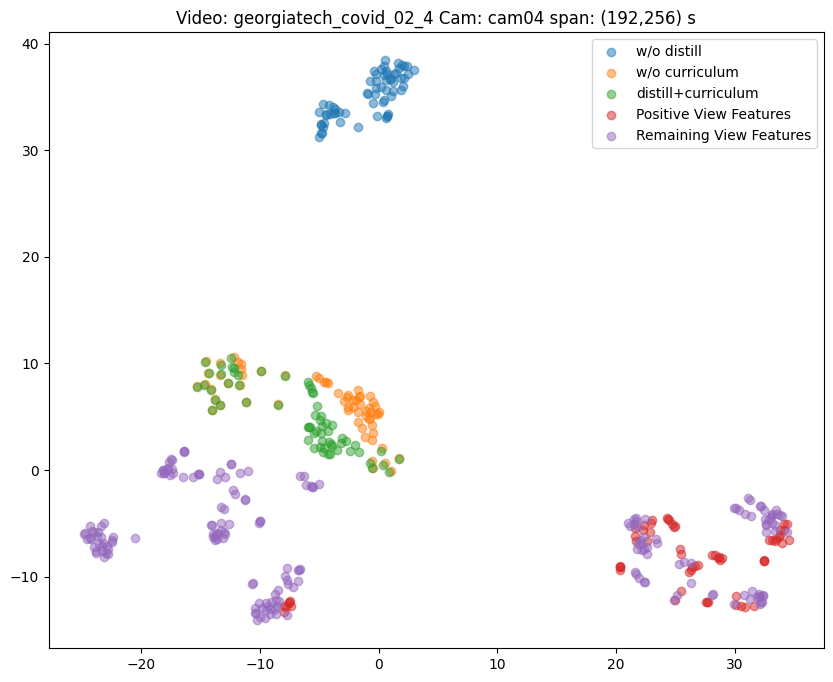

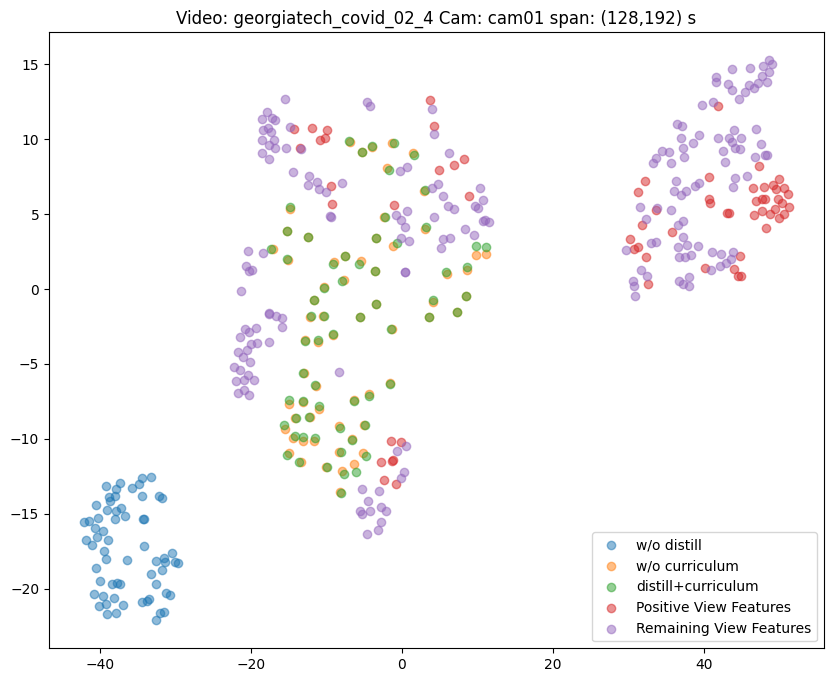

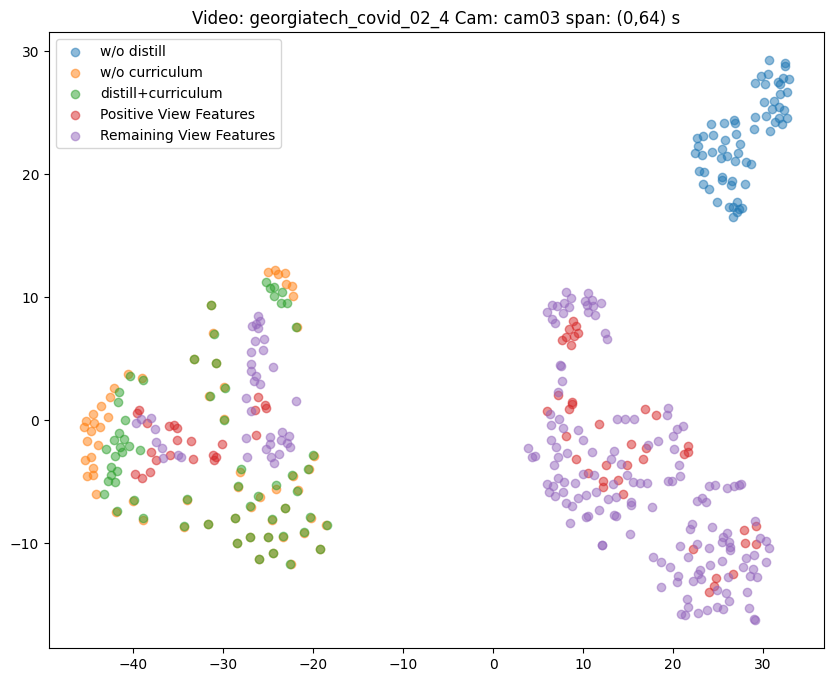

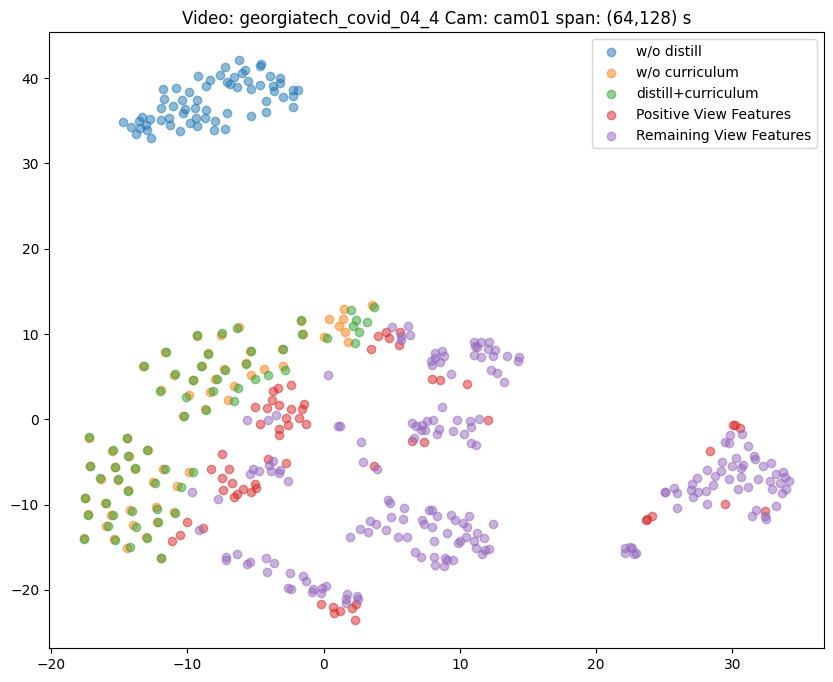

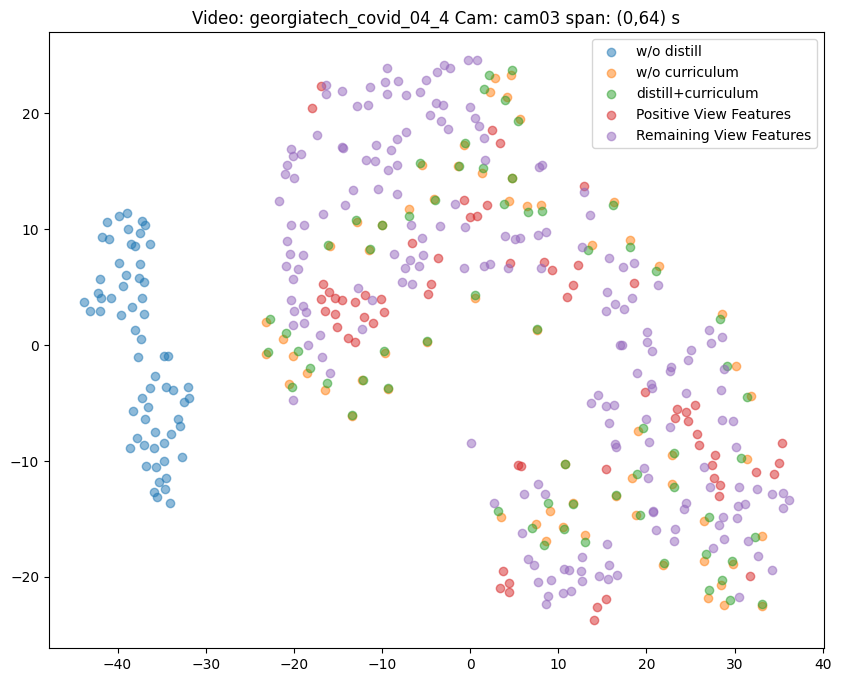

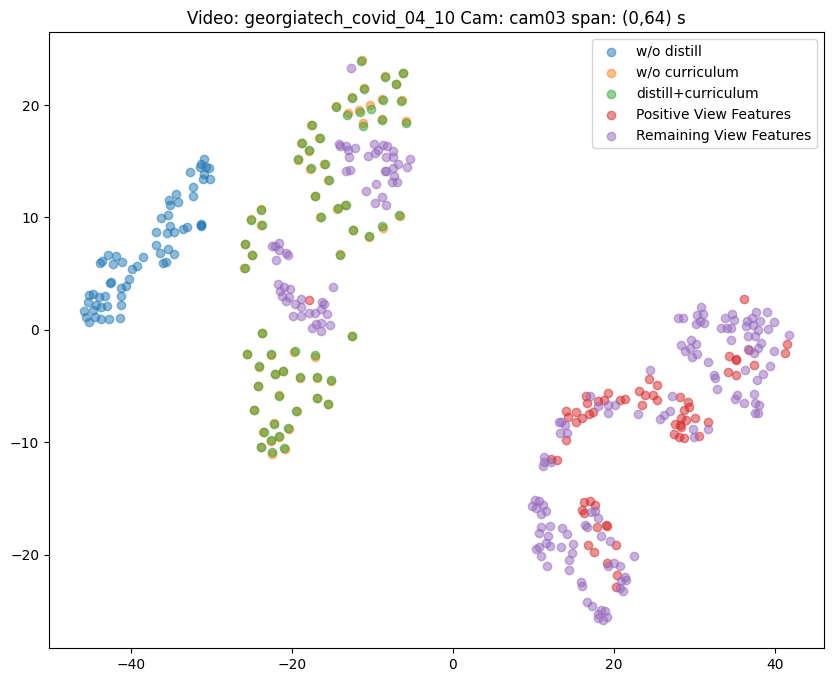

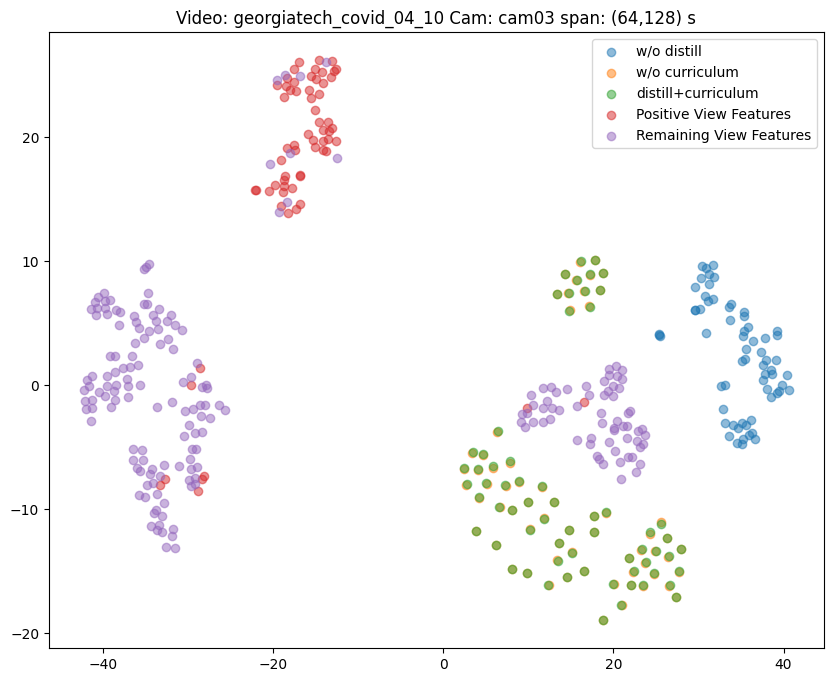

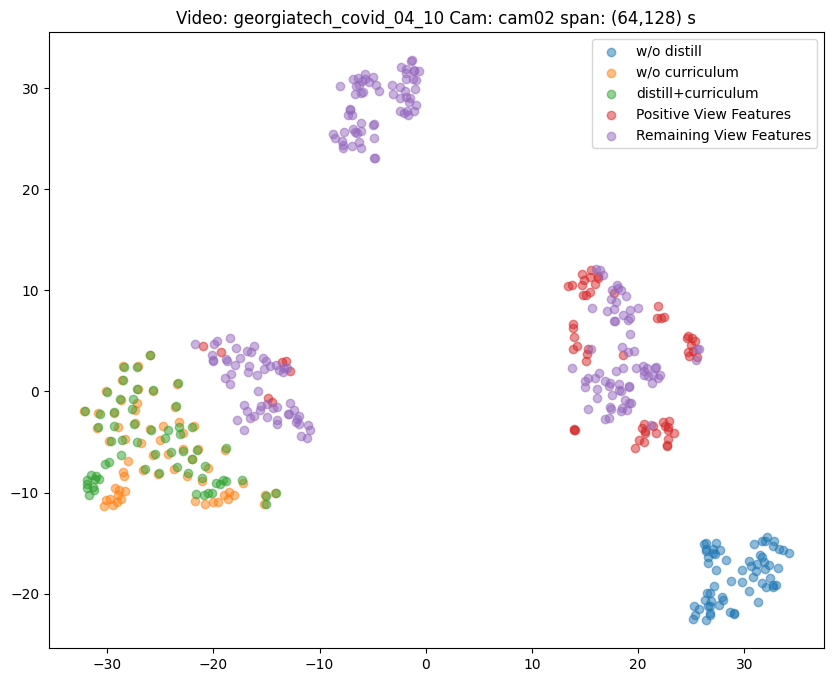

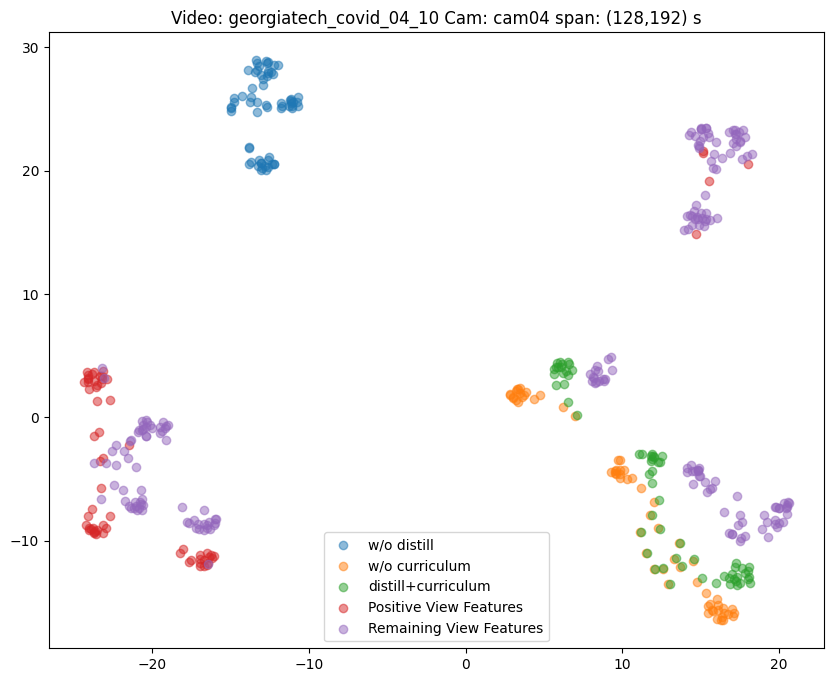

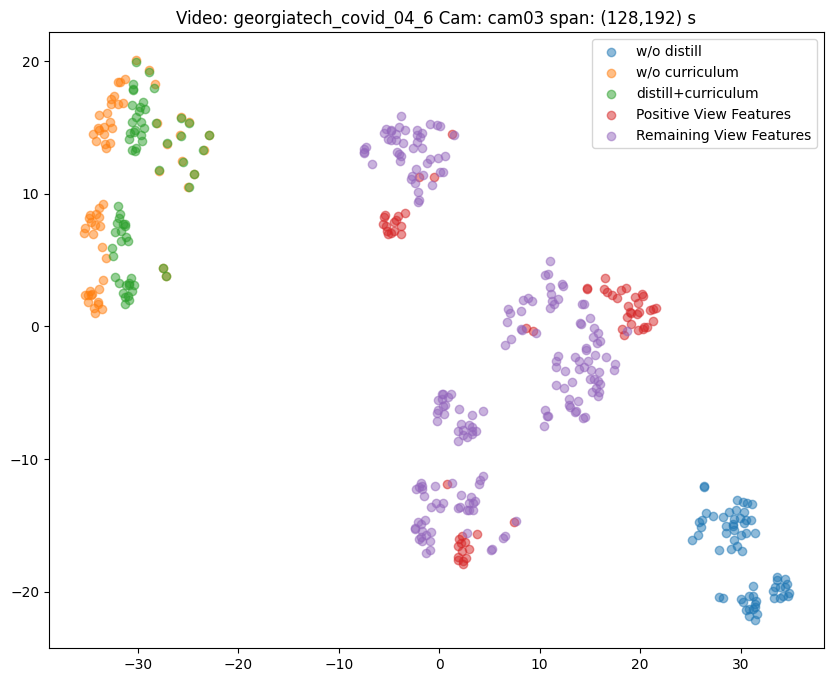

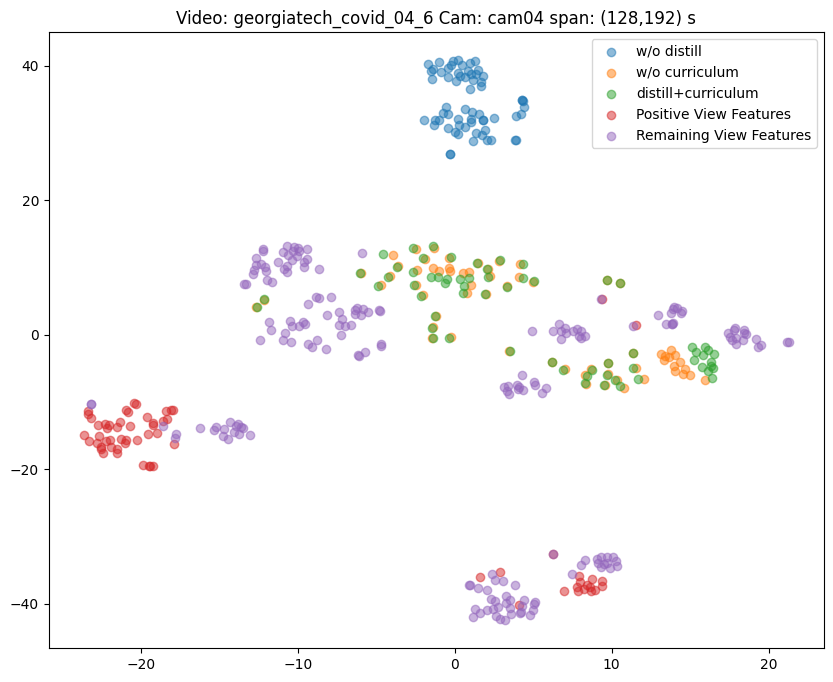

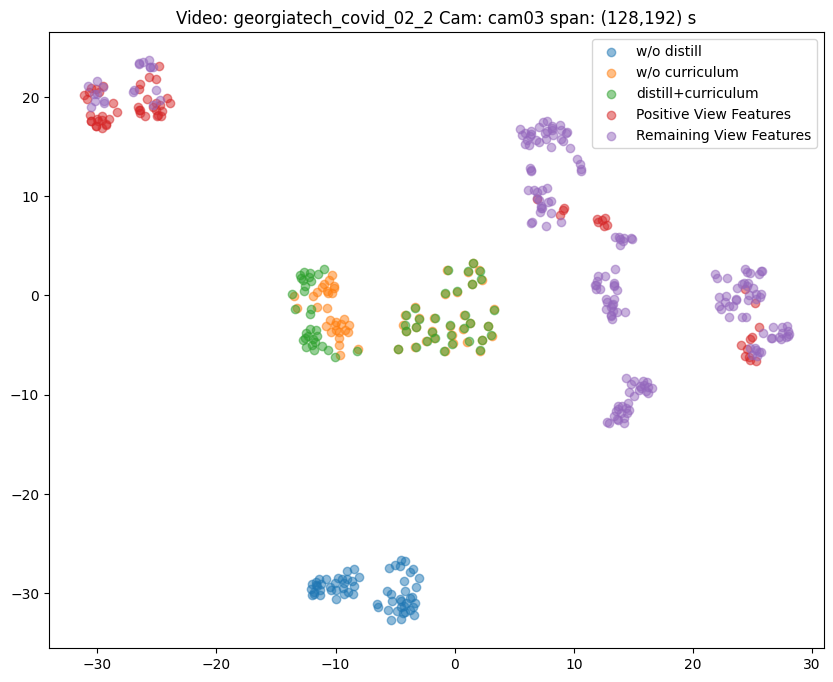

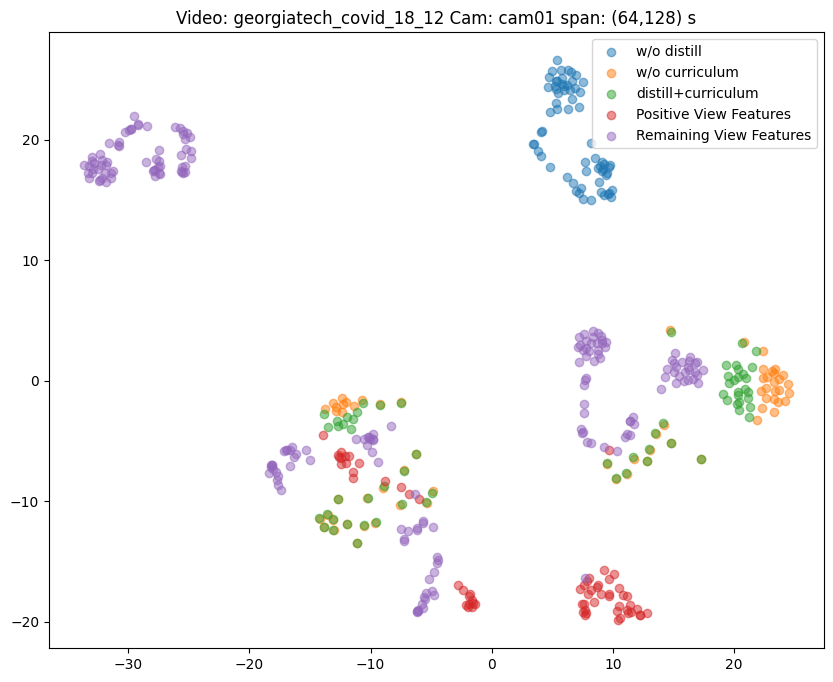

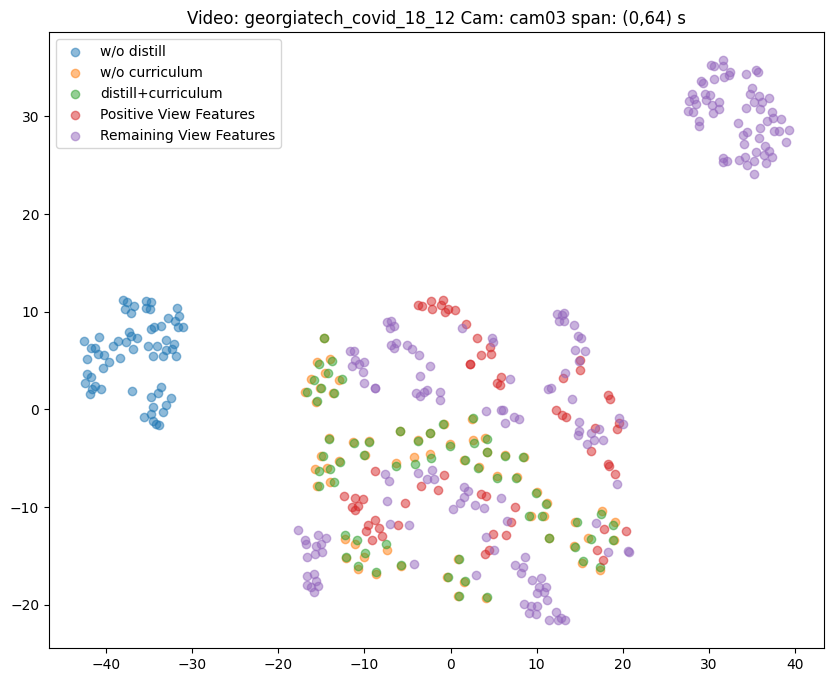

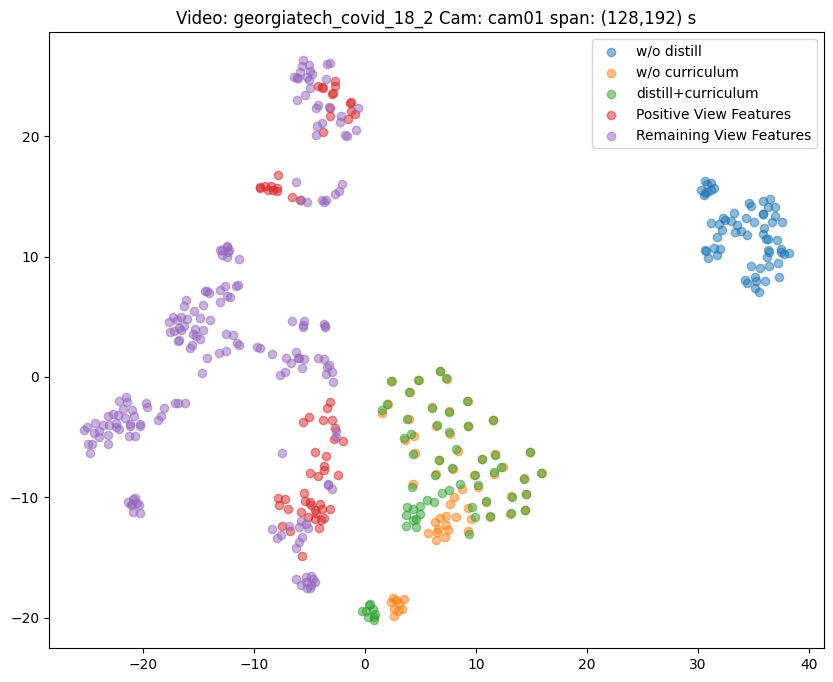

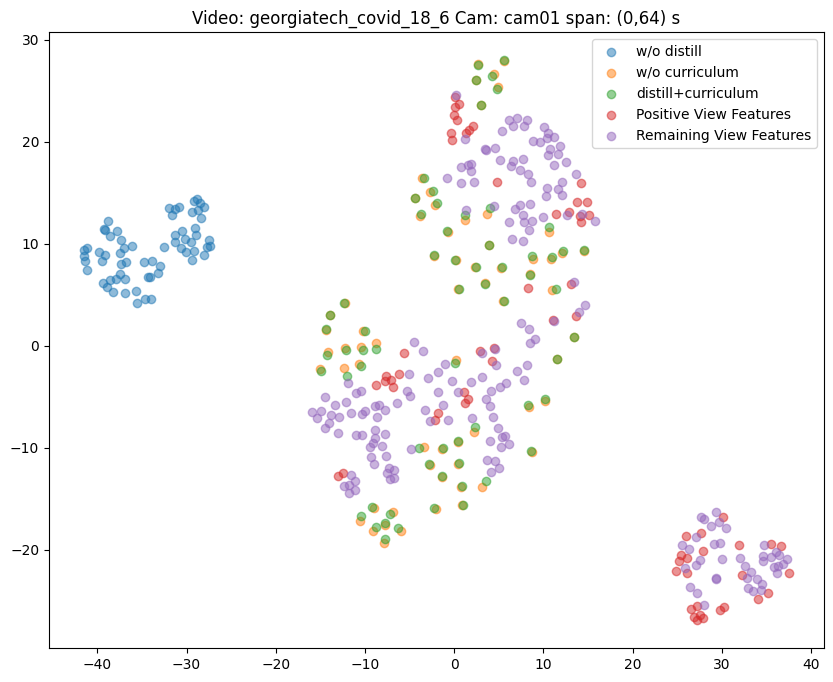

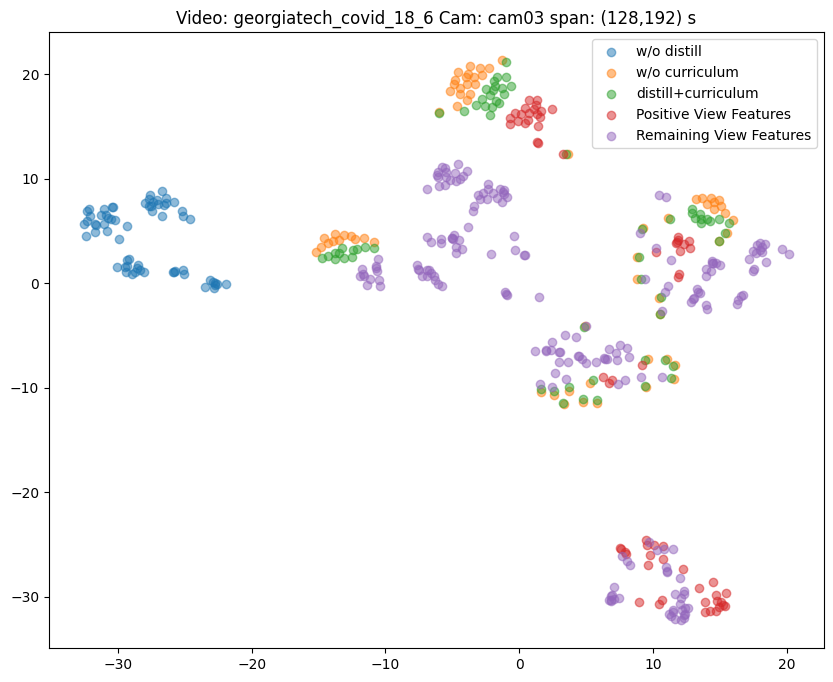

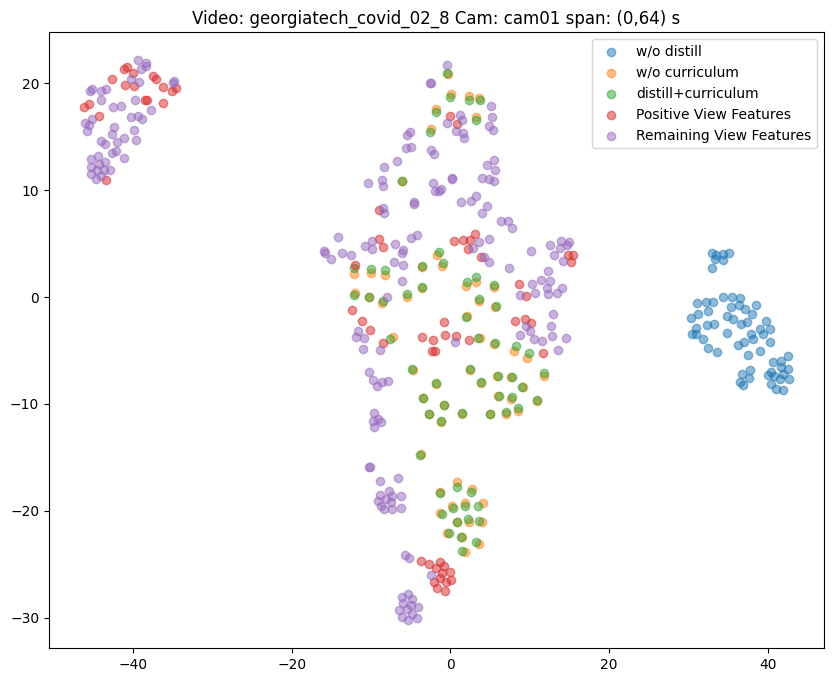

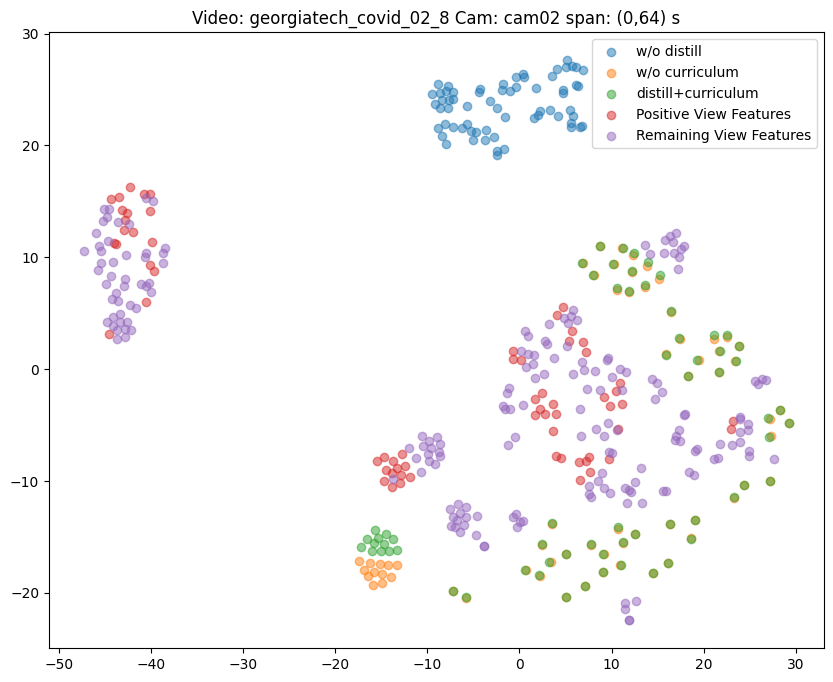

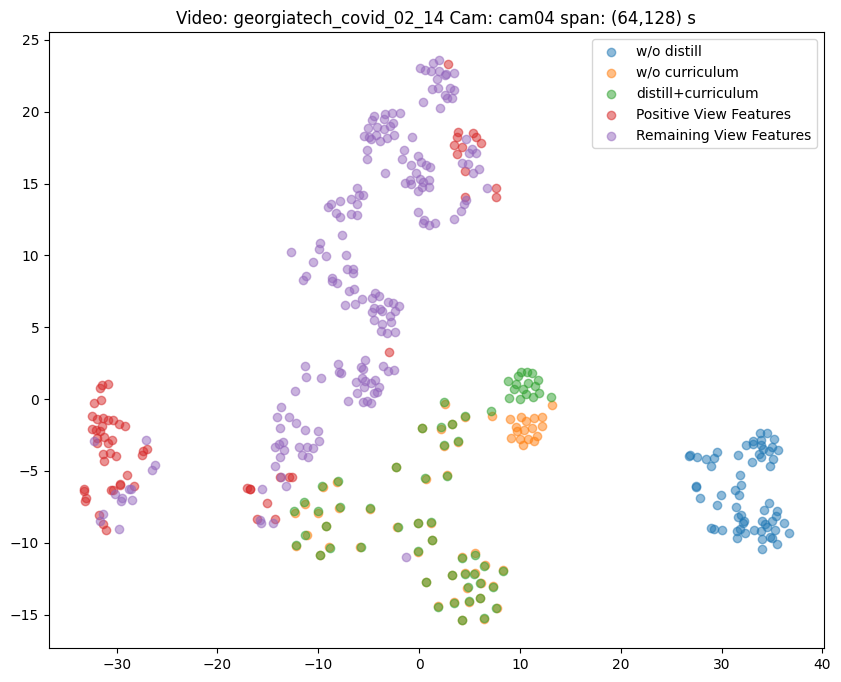

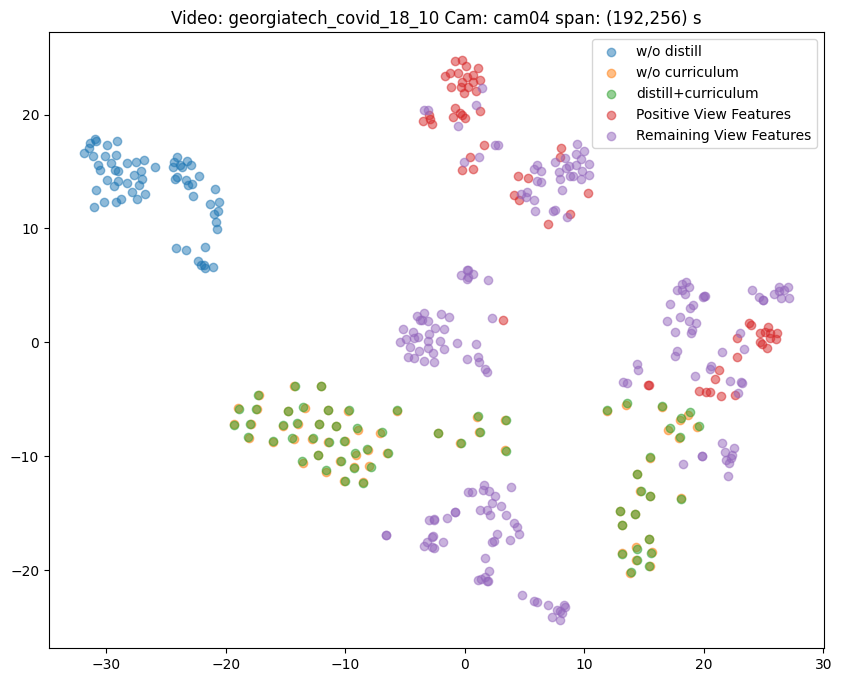

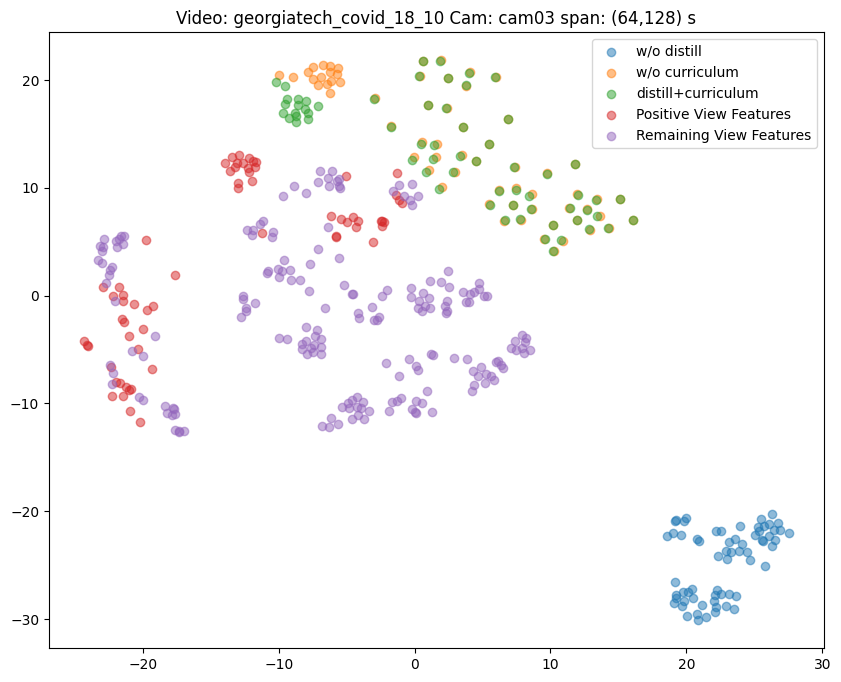

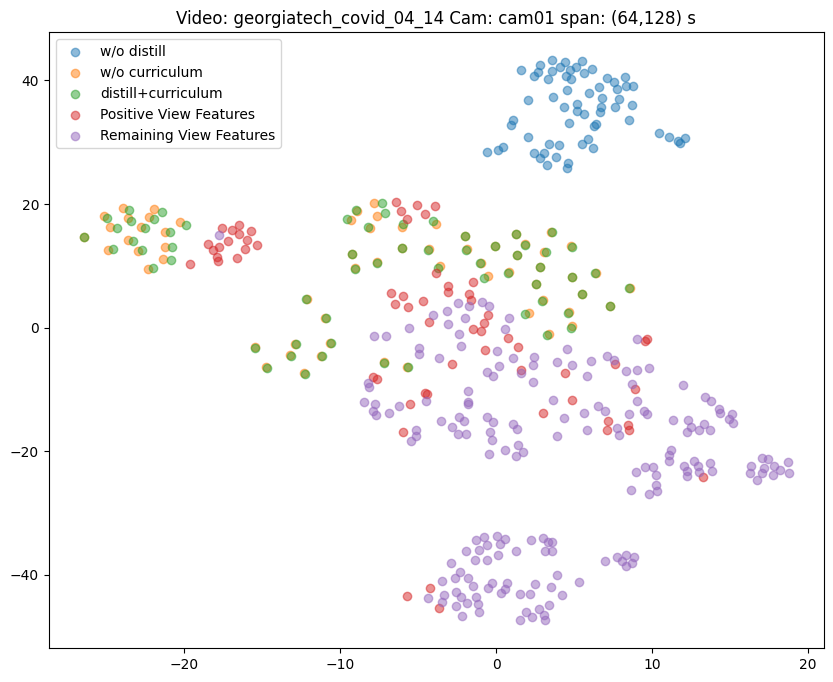

In [9]:
# Apply t-SNE
tsne_results = apply_tsne(normalized_input_features,
                            normalized_no_curr_features,
                            normalized_output_features,
                            normalized_all_view_features,
                            normalized_positive_view_features)

for i, tsne_result in enumerate(tsne_results):
        plot_tsne(tsne_result, 
                  len(normalized_input_features[i]),
                  len(normalized_no_curr_features[i]), 
                  len(normalized_output_features[i]), 
                  len(normalized_positive_view_features[i]),
                  outputs_distill['video_ids'][i],
                  outputs_distill['exo_cams'][i],
                  outputs_distill['start_secs'][i],
                  i, 
                  title="t-SNE Visualization")